In [465]:
# Libraries and and global variables

import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
import sklearn.metrics as metrics

K = None


In [466]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#Loading dataset for classification, scale and split test and train
iris = datasets.load_iris()
# Filter and conserve time 1 and 2 of iris
cond = (iris.target != 1)
y = iris.target[cond] - 1
y = y.astype('float')
x = iris.data[cond].astype('float')
x = preprocessing.scale(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)


In [467]:
sigma = .5

# SVM with rbf kernel
def fitNonLinear(x, y): 
    global K
    NUM = x.shape[0]
    DIM = x.shape[1]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    # we'll solve the dual
    # obtain the kernel
    K = metrics.pairwise.rbf_kernel(x, x, sigma)
    K = np.multiply(K, Ym)
    P = matrix(K)
    q = matrix(-np.ones((NUM, 1)))
    G = matrix(-np.eye(NUM))
    h = matrix(np.zeros(NUM))
    A = matrix(y.reshape(1, -1))
    b = matrix(np.zeros(1))
    solvers.options['show_progress'] = False
    sol = solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

In [468]:
#plot_data_with_labels(x, y)

# fit svm classifier
alphas = fitNonLinear(X_train, y_train)

# Get support vectors and b
cond = (alphas > 1e-4)
alpha_sv = alphas[cond]
n_sv = len(alpha_sv)
xCond = cond.reshape(-1)
x_sv = X_train[xCond, :]
y_sv = y_train[xCond]
K_sv = K[xCond,xCond]

b = np.mean(y_sv - K_sv*(np.multiply(alpha_sv, y_sv)))


In [469]:
ym = np.zeros(X_test.shape[0])
# Predict the test data
for j in range(X_test.shape[0]):
    x_p = X_test[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x_sv, sigma)
    ym[j] = np.sign(np.sum(np.multiply(np.multiply(alpha_sv,y_sv), K_pred)) + b)

In [470]:
from sklearn.metrics import confusion_matrix
#Create a confusion matrix to check the accuracy of the algorithm
confusion_matrix(y_test, ym)

array([[ 7,  0],
       [ 0, 18]], dtype=int64)

In [471]:
sigma = 3

# least square SVM with rbf kernel
def fitLS(x, y): 
    global K
    NUM = x.shape[0]
    DIM = x.shape[1]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)
    # we'll solve the dual
    # obtain the kernel
    K = metrics.pairwise.rbf_kernel(x, x, sigma)

    Omega = np.multiply(K, Ym)
    onev = np.ones((NUM, 1))
    gamma = 1
    
    yforA = np.reshape(y, (NUM, 1))
    
    A11 = np.zeros(1).reshape((1,1))
    A12 = yforA.T
    A21 = yforA
    A22 = Omega + np.eye(NUM)/gamma
    
    A1 = np.hstack((A11, A12))
    A2 = np.hstack((A21, A22))

    A =  np.vstack((A1, A2))
    
    B = np.vstack((A11, onev))
    
    sol = np.linalg.solve(A, B)
    b= sol[0]
    alpha=sol[1:]
    
    return {
        'b': b,
        'alphas': alpha
    }

In [472]:
# fit svm classifier
alphas = fitLS(X_train, y_train)
b = alphas['b']
alphas = alphas['alphas']

In [473]:
ym = np.zeros(X_test.shape[0])
# Predict the test data
for j in range(X_test.shape[0]):
    x_p = X_test[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], X_train, sigma)
    ym[j] = np.sign(np.sum(np.multiply(np.multiply(alphas,y_train), K_pred)) + b)

#Create a confusion matrix to check the accuracy of the algorithm
confusion_matrix(y_test, ym)

array([[ 7,  0],
       [ 0, 18]], dtype=int64)

In [464]:
sigma = 1

def fitLS_SVR(x, y): 
    global K
    NUM = x.shape[0]
    DIM = x.shape[1]
    
    Y = np.reshape(y, (NUM, 1))
    Ym = np.matmul(Y,Y.T)

    # we'll solve the dual
    # obtain the kernel
    K = metrics.pairwise.rbf_kernel(x, x, sigma)

    Omega = np.multiply(K, Ym)
    onev = np.ones((NUM, 1))
    gamma = 1
    
    yforA = np.reshape(y, (NUM, 1))

    A11 = np.zeros(1).reshape((1,1))
    A12 = onev.T
    A21 = onev
    A22 = Omega + np.eye(NUM)/gamma
    
    A1 = np.hstack((A11, A12))
    A2 = np.hstack((A21, A22))

    A =  np.vstack((A1, A2))
    
    B = np.vstack((A11, yforA))
    
    sol = np.linalg.solve(A, B)
    b= sol[0]
    alpha=sol[1:]
    
    return {
        'b': b,
        'alphas': alpha
    }

In [425]:
X, y = datasets.load_boston(return_X_y=True)
#x = preprocessing.scale(X)
x = X
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
x = np.sort(5 * np.random.rand(NUM, 1), axis=0)
y = np.sin(x).ravel()

#y_train = y_train.reshape((-1, 1))
#y_test = y_test.reshape((-1, 1))
print(y_train.shape)
print(y_test.shape)

# fit svm classifier
alphas = fitLS_SVR(X_train, y_train)

(379, 13)
(127, 13)
(379,)
(127,)
(379,)
(127,)


In [426]:
b = alphas['b']
alphas = alphas['alphas']
cond = (alphas > 1e-4)
#alpha_sv = alphas[cond]
#n_sv = len(alpha_sv)
#xCond = cond.reshape(-1)
#x_sv = X_train[xCond, :]
#y_sv = y_train[xCond]
#K_sv = K[xCond,xCond]

alpha_sv = alphas
n_sv = len(alpha_sv)
xCond = cond.reshape(-1)
x_sv = X_train
y_sv = y_train
K_sv = K[xCond,xCond]


In [427]:
len(alphas)
len(alpha_sv)

379

In [430]:
ym = np.zeros((y_test.shape[0]))

for j in range(y_test.shape[0]):
    x_p = X_test[j]
    K_pred = metrics.pairwise.rbf_kernel([x_p], x_sv, sigma)
    ym[j] = np.sum(np.multiply(alpha_sv, K_pred)) + b
    
#yplot = np.reshape(ym, (n1, n2))

In [432]:
from sklearn.metrics import explained_variance_score

explained_variance_score(y_test, ym)
#np.hstack((y_test, ym))

-2.220446049250313e-16

C:\Users\Tejon\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


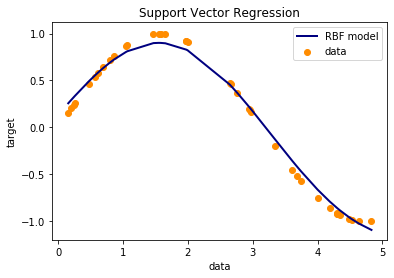

In [233]:
#SVR from sklearn

from sklearn.svm import SVR

X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

x = X


svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)
y_rbf = svr_rbf.fit(x, y).predict(x)
y_lin = svr_lin.fit(x, y).predict(x)
y_poly = svr_poly.fit(x, y).predict(x)

lw = 2
plt.scatter(x, y, color='darkorange', label='data')
plt.plot(x, y_rbf, color='navy', lw=lw, label='RBF model')
#plt.plot(x, y_lin, color='c', lw=lw, label='Linear model')
#plt.plot(x, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()